In [1]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine,Inspector
import json
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import reliability.Fitters as F
import reliability.Distributions as D
from datetime import datetime as dt
from sqlalchemy import text
today = dt.today().strftime('%Y-%m-%d')

In [2]:
plt.rcParams['font.family'] = 'SimHei'  # 替换为你选择的字体
today = dt.today().strftime('%Y-%m-%d')

In [3]:
# 定义数据库连接信息
db_username = 'develop'
db_password = 'Dev&168!'
db_port = '3306'
# db_hostname = '172.24.139.117'
# db_name = 'zlaq_gd_ana'

In [4]:
db_name = 'zlaq_prod'
db_hostname = '172.24.139.206'

In [5]:
# 创建数据库连接字符串
db_connection_str = f'mysql+pymysql://{db_username}:{db_password}@{db_hostname}:{db_port}/{db_name}'

In [6]:
# 创建数据库连接引擎
engine = create_engine(db_connection_str)
inspector = Inspector.from_engine(engine)
tables = inspector.get_table_names()

C:\Users\zhoufeng7\AppData\Local\Temp\ipykernel_21104\180711921.py:3: SADeprecationWarning: The from_engine() method on Inspector is deprecated and will be removed in a future release.  Please use the sqlalchemy.inspect() function on an Engine or Connection in order to acquire an Inspector. (deprecated since: 1.4)
  inspector = Inspector.from_engine(engine)


In [27]:
### 索赔单
claims_sql = '''
select * from
(select claim_guarantee_code,vin,guarantee_amount,
delivery_time,fault_time,
driving_mileage,
damage_material_code,damage_material_name,
vehicle_category_code,LEFT(vehicle_category_code,1) as vehicle_cate_merge,
usage_type_name
 from dwd_aftersale_claim_guarantee_order_df
where 1=1 
    and usage_type_name = '销售用车'
    and damage_material_code in ('M01B-21270033','M01-21270303')
) raw
where 1=1 
and vehicle_cate_merge = 'M'
'''
#读取粘贴列 VIN+里程+交付日期+故障日期
claims_raw = pd.read_clipboard()
#claims_raw = pd.read_sql(text(claims_sql), engine)



## 输出索赔单
#out_claims = pd.DataFrame(claims_raw)
#out_claims.to_clipboard(index=False)


In [23]:
###里程
mils_query = '''
select vin,total_odometer from dm_vom_drive_total_sum_df 
'''
# dm_vom_adas_total_odometer  
# dm_vom_drive_total_sum_df


mils_raw = pd.read_sql(mils_query, engine)

In [31]:
###车辆
vehicle_query = '''
select vin,vehicle_series_category_code,vehicle_model_name,factory_name,year_size,
left(actual_product_finish_time,10) as product_date, left(product_delivery_time,10) as delivery_date
from dim_pro_prod_vehicle_base_info_df 
where 1=1 
and vehicle_series_category_code  = 'X04'
and product_delivery_time is not null
-- and actual_product_finish_time >= '2023-10-01 00:00:00'
-- and actual_product_finish_time <= '2021-07-01 00:59:59'
'''
vehicle_raw = pd.read_sql(vehicle_query, engine)

print(len(claims_raw))
print(len(mils_raw))
print(len(vehicle_raw))


26
1207713
198637


In [35]:
### 车辆信息处理

# assert 3>4, "Houston we've got a problem"
claims = claims_raw.copy()
mils = mils_raw.copy()
vehicle = vehicle_raw.copy()

vehicle = vehicle.merge(mils,on='vin')

#粘贴列信息对齐
claims['vin'] = claims['VIN']
claims['total_odometer'] = claims['行驶里程']
claims['fault_time'] = claims['故障日期']


claims = claims.merge(vehicle[['vin','delivery_date','product_date']],how='left',on='vin')
#vehicle = vehicle.merge(mils,on='vin')
vehicle['use_days'] = (pd.to_datetime('2025-01-23') - pd.to_datetime(vehicle['delivery_date'])).dt.days
vehicle['use_days'] = vehicle['use_days'].apply( lambda x: x if x > 1 else 1)
claims['use_days']= (pd.to_datetime(claims['fault_time']) - pd.to_datetime(claims['delivery_date'])).dt.days
claims['use_days'] = claims['use_days'].apply( lambda x: x if x > 1 else 1)
#claims['total_odometer'] = claims['driving_mileage']
#assert 3>4, "Houston we've got a problem"

20 198637


C:\Users\zhoufeng7\AppData\Local\Temp\ipykernel_21104\1344837219.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_data.sort_values('use_days',inplace=True)
C:\Users\zhoufeng7\AppData\Local\Temp\ipykernel_21104\1344837219.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_data.drop_duplicates('vin',keep='first',inplace=True)


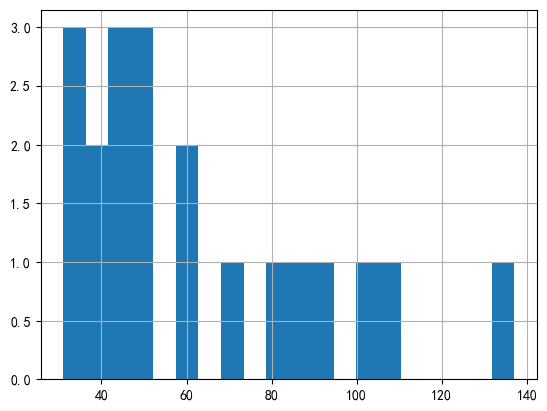

In [37]:
### 失效车与风险车处理

#assert 3>4


# ['vin_use', 'vehicle_series_category_code', 'vehicle_category_code', 'vehicle_model_name', 'ticket_create_time', 'product_date', 'delivery_date', 'year_size', 'retail_store_province_name',
#        'total_travel_mileage', 'extracted_value', 'part_code', 'part_barcode', 'mil_1000', 'accum_total_mileage']

# claims = claims.loc[claims['guarantee_type']==10]

failure_data = claims.loc[claims.vin.isin(vehicle.vin)]
failure_data['use_days'].hist(bins=20)
failure_data.sort_values('use_days',inplace=True)
failure_data.drop_duplicates('vin',keep='first',inplace=True)
# .loc[claims['ad_platform_name']=='AD MAX']
risk_data = vehicle

#vehicle['use_days'].hist(bins=20)


print(len(failure_data),len(risk_data))

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 20/198041 (99.9899% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI    Upper CI
    Alpha     1.14171e+06     2.04301e+06   34228.1 3.80825e+07
     Beta         1.01178         0.20177  0.684443     1.49566 

Goodness of fit    Value
 Log-likelihood -301.058
           AICc  606.116
            BIC  626.509
             AD  532.471 



Text(0.5, 1.0, '断点前后-天数')

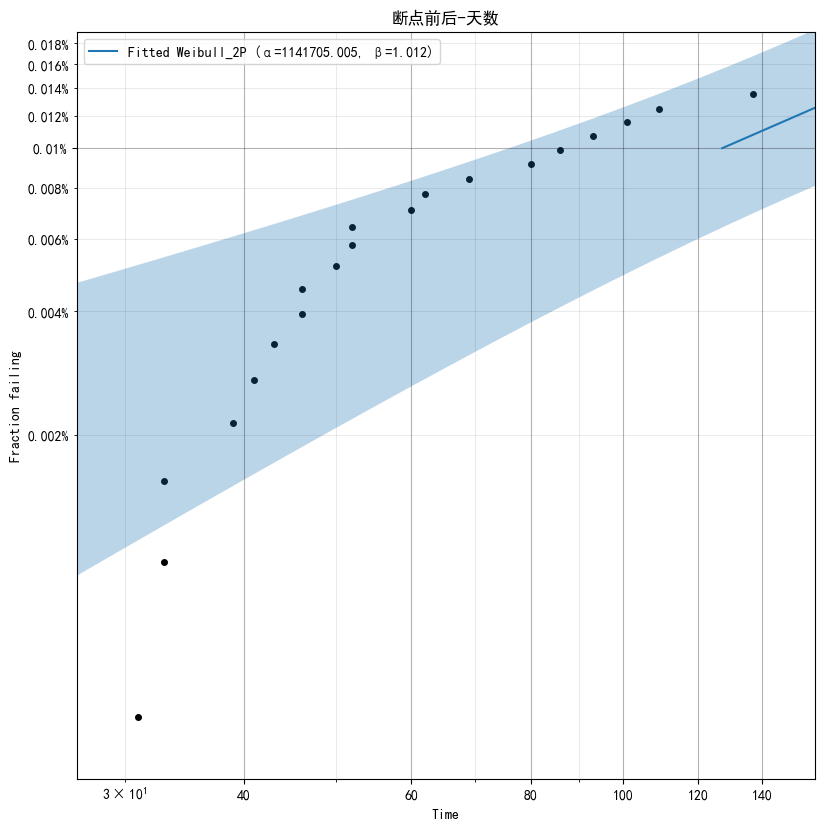

In [39]:
### 按故障天数



left_data = failure_data.loc[(failure_data['product_date']>'2024-04-01')&(
                        failure_data['use_days']>1)]
right_data= risk_data.loc[(risk_data['product_date']>'2024-04-01')
                        &(~risk_data['vin'].isin(failure_data['vin']))]
output = F.Fit_Weibull_2P(
    left_data['use_days'].tolist(),
    right_censored = right_data['use_days'].tolist(),
    CI_type='reliability')
# plt.title('断点后-里程')

#left_data = failure_data.loc[(failure_data['product_date']<='2021-01-01')&(
#                        failure_data['use_days']>100)]
#right_data= risk_data.loc[(risk_data['product_date']<='2021-01-01')
#                        &(~risk_data['vin'].isin(failure_data['vin']))]
#output = F.Fit_Weibull_2P(
#    left_data['use_days'].tolist(),
#    right_censored = right_data['use_days'].tolist(),
#    CI_type='reliability')
plt.title('断点前后-天数')

1800天故障率在0.0504%到0.4226%之间，估计损失件在100到839之间。更高天数数据缺乏证据，仅作为参考。


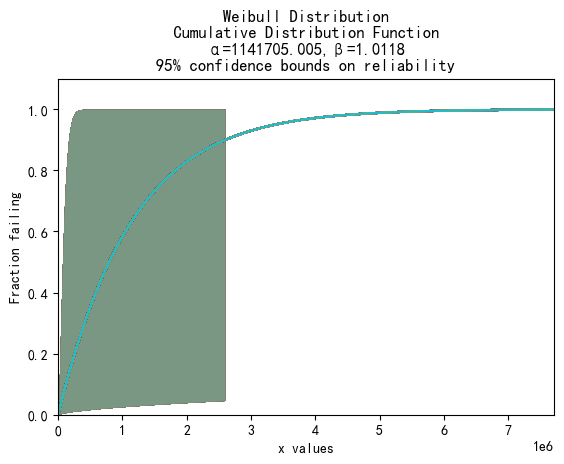

In [40]:
### 故障率分析 


new_rate = len(failure_data.loc[failure_data['use_days']<=30])/len(risk_data)

# new_rate = 0
out = pd.DataFrame()
# out['total_odometer'] = [10000*i for i in range(1,11)]
## 100000公里质保
out['use_days'] = [30 *(i+1)for i in range(60)]
## 60个月质保

out['平均(%)'] = out['use_days'].apply(lambda x : (1 - output.distribution.SF(x))*100) +new_rate*100
out['95%上限(%)']=  out['use_days'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[-1]*100) +new_rate*100
out['95%下限(%)']=  out['use_days'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[0]*100) +new_rate*100

out.to_clipboard(index=False)

#miles = 100000
usedays = 1800
use = out.loc[out['use_days'] == usedays]

rate_ = use.values.reshape(-1)[2:]
num_ = len(risk_data) * rate_/100 
print(f"{usedays}天故障率在{min(rate_) :.4f}%到{max(rate_) :.4f}%之间，估计损失件在{min(num_) :.0f}到{max(num_) :.0f}之间。更高天数数据缺乏证据，仅作为参考。")

20 198637


C:\Users\zhoufeng7\AppData\Local\Temp\ipykernel_21104\1622878018.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_data.sort_values('total_odometer',inplace=True)
C:\Users\zhoufeng7\AppData\Local\Temp\ipykernel_21104\1622878018.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_data.drop_duplicates('vin',keep='first',inplace=True)


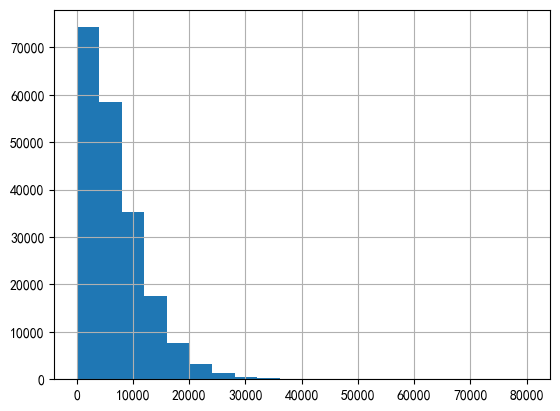

In [43]:
### 按里程分布

#assert 3>4
#claims = claims_raw.copy()
#vehicle = vehicle_raw.copy()
#mils = mils_raw.copy()

#vehicle = vehicle.merge(mils_raw,on='vin')
# ['vin_use', 'vehicle_series_category_code', 'vehicle_category_code', 'vehicle_model_name', 'ticket_create_time', 'product_date', 'delivery_date', 'year_size', 'retail_store_province_name',
#        'total_travel_mileage', 'extracted_value', 'part_code', 'part_barcode', 'mil_1000', 'accum_total_mileage']

# claims = claims.loc[claims['guarantee_type']==10]
#claims['vin'] = claims['VIN']
#claims = claims.merge(vehicle[['vin','delivery_date','product_date']],how='left',on='vin')
#claims['total_odometer'] = claims['driving_mileage']
#failure_data = claims.loc[claims.vin.isin(vehicle.vin)]
#failure_data['total_odometer'].hist(bins=20)
failure_data.sort_values('total_odometer',inplace=True)
failure_data.drop_duplicates('vin',keep='first',inplace=True)
# .loc[claims['ad_platform_name']=='AD MAX']
risk_data = vehicle

risk_data['total_odometer'].hist(bins=20)


print(len(failure_data),len(risk_data))

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 20/198041 (99.9899% right censored) 

Parameter  Point Estimate  Standard Error    Lower CI    Upper CI
    Alpha     2.64105e+07      3.7948e+07 1.58025e+06 4.41395e+08
     Beta         1.11909         0.20135    0.786525     1.59226 

Goodness of fit    Value
 Log-likelihood -380.499
           AICc  764.998
            BIC   785.39
             AD  532.409 



Text(0.5, 1.0, '断点前后-里程')

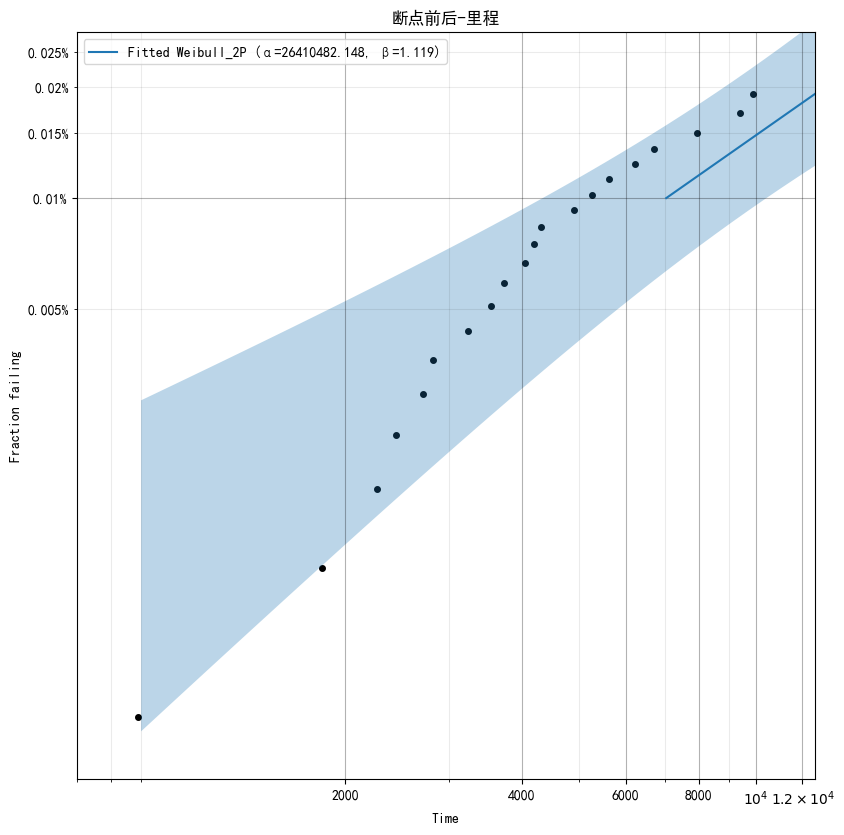

In [45]:
#assert 3>4, "Houston we've got a problem"
#故障件预处理

left_data = failure_data.loc[(failure_data['product_date']>'2024-04-01')&
                       (failure_data['total_odometer']>1)]
right_data= risk_data.loc[(risk_data['product_date']>'2024-04-01')
                        &(~risk_data['vin'].isin(failure_data['vin']))]

output = F.Fit_Weibull_2P(
    left_data['total_odometer'].tolist(),
    right_censored = right_data['total_odometer'].tolist(),
    CI_type='reliability')
# plt.title('断点后-里程')


#left_data = failure_data.loc[(failure_data['product_date']<='2021-01-01')&
#                        (failure_data['total_odometer']>2000)]
#right_data= risk_data.loc[(risk_data['product_date']<='2021-01-101')
#                        &(~risk_data['vin'].isin(failure_data['vin']))]

#output = F.Fit_Weibull_2P(
#    left_data['total_odometer'].tolist(),
#    right_censored = right_data['total_odometer'].tolist(),
#    CI_type='reliability')
plt.title('断点前后-里程')


100000公里故障率在0.0703%到0.5387%之间，估计损失件在140到1070之间。更高里程数据缺乏证据，仅作为参考。


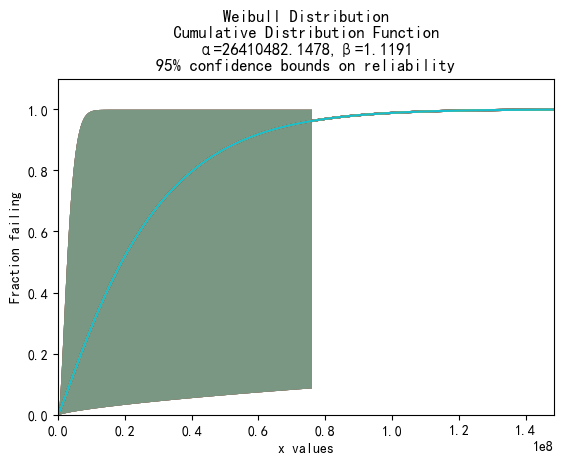

In [46]:
# new_rate = 0
out = pd.DataFrame()
out['total_odometer'] = [10000*i for i in range(1,11)]
# out['使用天数'] = [30 *(i+1)for i in range(96)]

out['平均(%)'] = out['total_odometer'].apply(lambda x : (1 - output.distribution.SF(x))*100) +new_rate*100
out['95%上限(%)']=  out['total_odometer'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[-1]*100) +new_rate*100
out['95%下限(%)']=  out['total_odometer'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[0]*100) +new_rate*100

out.to_clipboard(index=False)

miles = 100000
use = out.loc[out['total_odometer'] == miles]

rate_ = use.values.reshape(-1)[2:]
num_ = len(risk_data) * rate_/100 
print(f"{miles}公里故障率在{min(rate_) :.4f}%到{max(rate_) :.4f}%之间，估计损失件在{min(num_) :.0f}到{max(num_) :.0f}之间。更高里程数据缺乏证据，仅作为参考。")


Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 1556/170060 (99.09332% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         1323.84         2.30964   1319.32   1328.37
     Beta         25.3799        0.371831   24.6615   26.1192 

Goodness of fit    Value
 Log-likelihood -12907.5
           AICc  25818.9
            BIC    25839
             AD  172.387 



Text(0.5, 1.0, '断点后-使用天数')

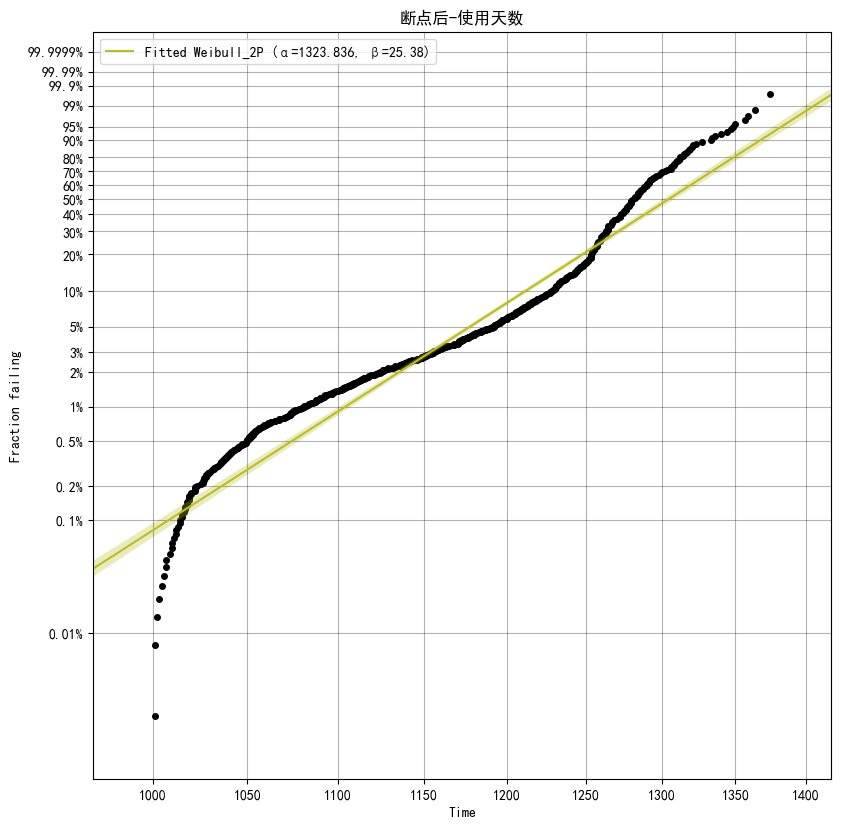

In [22]:
new_rate = 0
out = pd.DataFrame()
out['里程'] = [10000*i for i in range(1,16)]
# out['使用天数'] = [30 *(i+1)for i in range(96)]

out['平均(%)'] = out['里程'].apply(lambda x : (1 - output.distribution.SF(x))*100) +new_rate*100
out['95%上限(%)']=  out['里程'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[-1]*100) +new_rate*100
out['95%下限(%)']=  out['里程'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[0]*100) +new_rate*100


new_rate = 0
out = pd.DataFrame()
out['use_days'] = [100*i for i in range(1,20)]
# out['使用天数'] = [30 *(i+1)for i in range(96)]

out['平均(%)'] = out['use_days'].apply(lambda x : (1 - output.distribution.SF(x))*100) +new_rate*100
out['95%上限(%)']=  out['use_days'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[-1]*100) +new_rate*100
out['95%下限(%)']=  out['use_days'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[0]*100) +new_rate*100


left_data = claims.loc[(claims['product_date']>'2021-01-15')&(claims['use_days']>1000)]
right_data= vehicle.loc[(vehicle['product_date']>'2021-01-15')
                        &(~vehicle['vin'].isin(claims['vin']))]

output = F.Fit_Weibull_2P(
    left_data['use_days'].tolist(),
    right_censored = right_data['use_days'].tolist(),
    CI_type='reliability')
plt.title('断点后-使用天数')


Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: L-BFGS-B
Failures / Right censored: 6529/33350 (83.62797% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         1724.88          3.4399   1718.15   1731.64
     Beta         9.42316       0.0906893   9.24707   9.60259 

Goodness of fit    Value
 Log-likelihood -54955.2
           AICc   109914
            BIC   109931
             AD  505.773 



1825

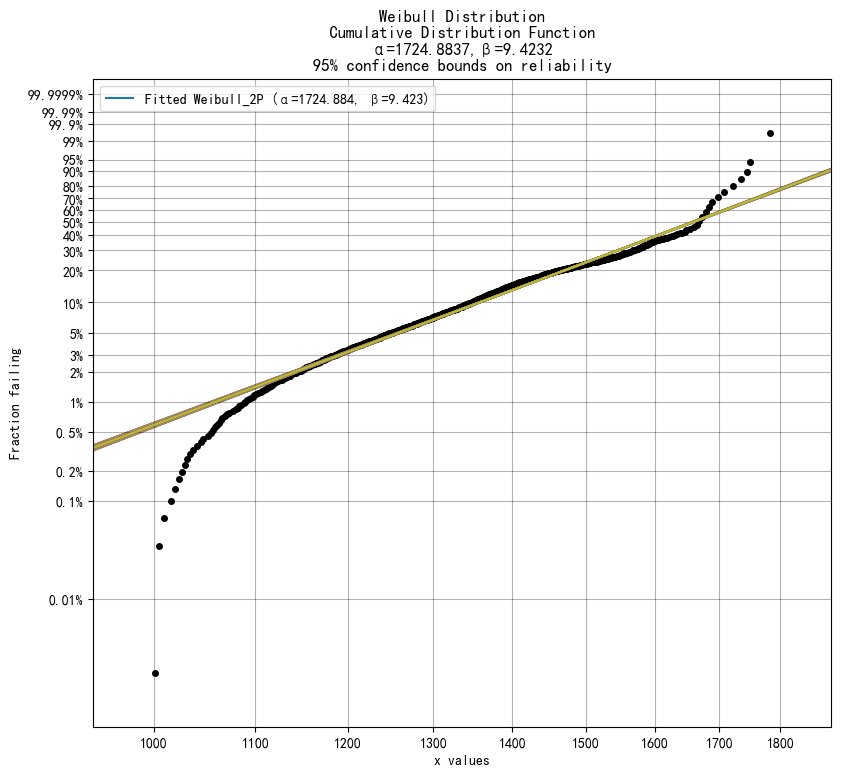

In [23]:
left_data = claims.loc[(claims['product_date']<='2021-01-15')&(claims['use_days']>1000)]
right_data= vehicle.loc[(vehicle['product_date']<='2021-01-15')
                        &(~vehicle['vin'].isin(claims['vin']))]

output = F.Fit_Weibull_2P(
    left_data['use_days'].tolist(),
    right_censored = right_data['use_days'].tolist(),
    CI_type='reliability')
plt.title('断点后-使用天数')



new_rate = 0
out = pd.DataFrame()
out['使用天数'] = [200*i for i in range(1,10)]
# out['使用天数'] = [30 *(i+1)for i in range(96)]

out['平均(%)'] = out['使用天数'].apply(lambda x : (1 - output.distribution.SF(x))*100) +new_rate*100
out['95%上限(%)']=  out['使用天数'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[-1]*100) +new_rate*100
out['95%下限(%)']=  out['使用天数'].apply(lambda x : output.distribution.CDF(CI_x=[x], CI=0.95)[0]*100) +new_rate*100


5*365
# 供应商保修 3年6万， 理想汽车5年10万